In [1]:
import spacy
import string
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Data Preparation

In [66]:
# Read in the Yelp Reviews dataset and segment for this use case - reviews text, and stars
reviews = pd.read_csv('reviews.csv', nrows=10000)
reviews = reviews[['stars','text']]

In [3]:
# Load in NLP and stopwords objects
nlp = spacy.load('en', parser=False, entity=False)
stopwords = spacy.lang.en.stop_words.STOP_WORDS

In [67]:
# Look at the data
reviews.shape

(10000, 2)

In [68]:
reviews.head()

,stars,text
0,1,Total bill for this horrible service? Over $8G...
1,5,I *adore* Travis at the Hard Rock's new Kelly ...
2,5,I have to say that this office really has it t...
3,5,Went in for a lunch. Steak sandwich was delici...
4,1,Today was my second out of three sessions I ha...


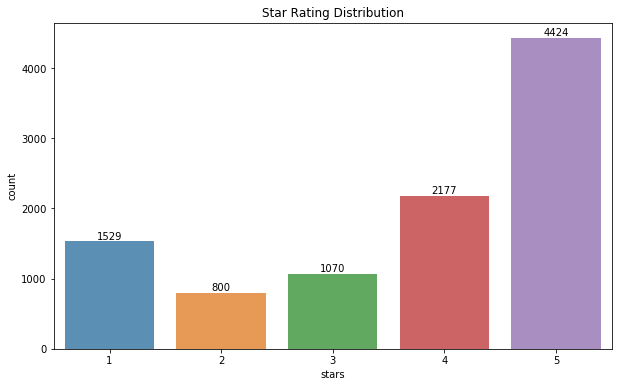

In [69]:
# Plot the reviews star distribution
x = reviews['stars'].value_counts()
x = x.sort_index()
plt.figure(figsize=(10,6))
ax = sns.barplot(x.index, x.values, alpha=0.8)
plt.title("Star Rating Distribution")
plt.ylabel('count')
plt.xlabel('stars')
rects = ax.patches
labels = x.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')
plt.show();

In [70]:
# Now, drop neutral reviews to create binary variable
reviews = reviews[reviews.stars != 3]

# Recode stars into positive and negative binary variable (for univariate sentiment analysis)
def positive_review(series):
    if series > 3:
        return "1"
    elif series < 3:
        return "0"

# Apply function
reviews['review_type'] = reviews['stars'].apply(positive_review)

# Remove stars variable
reviews = reviews[['text', 'review_type']]

reviews.shape

(8930, 2)

In [73]:
sum(float(num) == 1 for num in reviews['review_type'])

/anaconda3/envs/nlp-36/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  """Entry point for launching an IPython kernel.


6601

In [74]:
sum(float(num) == 0 for num in reviews['review_type'])

/anaconda3/envs/nlp-36/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  """Entry point for launching an IPython kernel.


2329

## Feature Engineering

In [75]:
# Create feature for review length and % of punct in original review
import string

# Function to calculate length of message including space
reviews['review_len'] = reviews['text'].apply(lambda x: len(x) - x.count(" "))

reviews.head()

,text,review_type,review_len
0,Total bill for this horrible service? Over $8G...,0,166
1,I *adore* Travis at the Hard Rock's new Kelly ...,1,1274
2,I have to say that this office really has it t...,1,503
3,Went in for a lunch. Steak sandwich was delici...,1,343
4,Today was my second out of three sessions I ha...,0,2837


In [76]:
# Add feature for mean review length before cleaning
reviews.loc[:, "review_len"].mean()

464.7195968645017

In [77]:
# Group by type...
reviews.groupby('review_type', as_index=False)['review_len'].mean()

,review_type,review_len
0,0,580.660799
1,1,423.812604


In [78]:
# Add feature for % punctuation for review
def count_punct(text):
    count = sum([1 for char in text if char in string.punctuation])
    return round(count/(len(text) - text.count(" ")), 3)*100

reviews['punct%'] = reviews['text'].apply(lambda x: count_punct(x))

reviews.head()

,text,review_type,review_len,punct%
0,Total bill for this horrible service? Over $8G...,0,166,4.2
1,I *adore* Travis at the Hard Rock's new Kelly ...,1,1274,3.9
2,I have to say that this office really has it t...,1,503,3.0
3,Went in for a lunch. Steak sandwich was delici...,1,343,5.2
4,Today was my second out of three sessions I ha...,0,2837,3.3


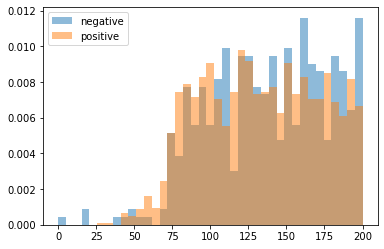

In [79]:
# Check out how features help
# Plot negative and positive review lengths against each other
bins = np.linspace(0, 200, 40)

plt.hist(reviews[reviews['review_type']=='0']['review_len'], bins, alpha=0.5, density=True, label='negative')
plt.hist(reviews[reviews['review_type']=='1']['review_len'], bins, alpha=0.5, density=True, label='positive')
plt.legend(loc='upper left')
plt.show()

# Seems to be an interesting feature - negative reviews seem to have longer length reviews at times.

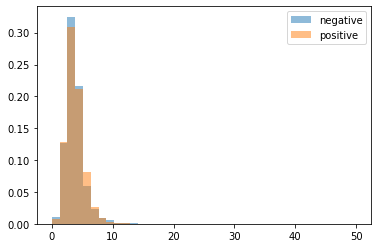

In [80]:
# Plot negative and positive reviews % punctuation against each other
bins = np.linspace(0, 50, 40)

plt.hist(reviews[reviews['review_type']=='0']['punct%'], bins, alpha=0.5, density=True, label='negative')
plt.hist(reviews[reviews['review_type']=='1']['punct%'], bins, alpha=0.5, density=True, label='positive')
plt.legend(loc='upper right')
plt.show()

# Doesn't seem to be a great feature - little  difference between the two

## Data Pre-Processing

### Cleaning

In [81]:
# Removing punctuation/characters/numbers/multiple spaces as a result
def remove_punct(text):
    # first punctuation
    text_nopunct = "".join([char for char in text if char not in string.punctuation])
    # then odd char that snuck in past encoding
    text_nochar = re.sub(r'[^a-zA-Z0-9_\s]+', '', text_nopunct)
    # then any numbers
    text_nonumb = re.sub(r'\d+', '', text_nochar)
    # sub multiple spaces with single space
    text_nospace = re.sub(r'\s+', ' ', text_nonumb, flags=re.I)
    return text_nospace

reviews['reviews_cleaned'] = reviews['text'].apply(lambda x: remove_punct(x))

reviews.head()

,text,review_type,review_len,punct%,reviews_cleaned
0,Total bill for this horrible service? Over $8G...,0,166,4.2,Total bill for this horrible service Over Gs T...
1,I *adore* Travis at the Hard Rock's new Kelly ...,1,1274,3.9,I adore Travis at the Hard Rocks new Kelly Car...
2,I have to say that this office really has it t...,1,503,3.0,I have to say that this office really has it t...
3,Went in for a lunch. Steak sandwich was delici...,1,343,5.2,Went in for a lunch Steak sandwich was delicio...
4,Today was my second out of three sessions I ha...,0,2837,3.3,Today was my second out of three sessions I ha...


### Lemmatizer

In [82]:
# Lemmatize & normalize
def lemmatize_text(docs):
    texts = []
    doc = nlp(docs, disable=['parser','new'])
    tokens = [tok.lemma_.lower().strip() for tok in doc if tok.lemma_ != '-PRON-'] # pronouns
    tokens = [tok for tok in tokens if tok not in stopwords] # stopwords
    tokens = ' '.join(tokens) # join above
    texts.append(tokens)
    return pd.Series(texts)

reviews['reviews_lemmatized'] = reviews['reviews_cleaned'].apply(lambda x: lemmatize_text(x))

reviews.head()

,text,review_type,review_len,punct%,reviews_cleaned,reviews_lemmatized
0,Total bill for this horrible service? Over $8G...,0,166,4.2,Total bill for this horrible service Over Gs T...,total bill horrible service gs crook actually ...
1,I *adore* Travis at the Hard Rock's new Kelly ...,1,1274,3.9,I adore Travis at the Hard Rocks new Kelly Car...,adore travis hard rocks new kelly cardenas sal...
2,I have to say that this office really has it t...,1,503,3.0,I have to say that this office really has it t...,office organized friendly dr j phillipp great ...
3,Went in for a lunch. Steak sandwich was delici...,1,343,5.2,Went in for a lunch Steak sandwich was delicio...,lunch steak sandwich delicious caesar salad ab...
4,Today was my second out of three sessions I ha...,0,2837,3.3,Today was my second out of three sessions I ha...,today second session pay session tell meredith...


In [83]:
# Length of reviews after lemmatize
reviews['review_len_lemma'] = reviews['reviews_lemmatized'].apply(lambda x: len(x) - x.count(" "))

reviews.head()

,text,review_type,review_len,punct%,reviews_cleaned,reviews_lemmatized,review_len_lemma
0,Total bill for this horrible service? Over $8G...,0,166,4.2,Total bill for this horrible service Over Gs T...,total bill horrible service gs crook actually ...,93
1,I *adore* Travis at the Hard Rock's new Kelly ...,1,1274,3.9,I adore Travis at the Hard Rocks new Kelly Car...,adore travis hard rocks new kelly cardenas sal...,683
2,I have to say that this office really has it t...,1,503,3.0,I have to say that this office really has it t...,office organized friendly dr j phillipp great ...,252
3,Went in for a lunch. Steak sandwich was delici...,1,343,5.2,Went in for a lunch Steak sandwich was delicio...,lunch steak sandwich delicious caesar salad ab...,200
4,Today was my second out of three sessions I ha...,0,2837,3.3,Today was my second out of three sessions I ha...,today second session pay session tell meredith...,1277


In [84]:
reviews.loc[:, "review_len_lemma"].mean()

242.97939529675253

In [85]:
reviews.groupby('review_type', as_index=False)['review_len_lemma'].mean()

,review_type,review_len_lemma
0,0,284.773293
1,1,228.233449


In [86]:
# Create word count column for cleaned reviews, and lemamtized
reviews['word_count'] = reviews['reviews_cleaned'].apply(lambda x: len(str(x).split()))
reviews['word_count_lemma'] = reviews['reviews_lemmatized'].apply(lambda x: len(str(x).split()))

In [87]:
reviews.head(20)

,text,review_type,review_len,punct%,reviews_cleaned,reviews_lemmatized,review_len_lemma,word_count,word_count_lemma
0,Total bill for this horrible service? Over $8G...,0,166,4.2,Total bill for this horrible service Over Gs T...,total bill horrible service gs crook actually ...,93,36,18
1,I *adore* Travis at the Hard Rock's new Kelly ...,1,1274,3.9,I adore Travis at the Hard Rocks new Kelly Car...,adore travis hard rocks new kelly cardenas sal...,683,270,117
2,I have to say that this office really has it t...,1,503,3.0,I have to say that this office really has it t...,office organized friendly dr j phillipp great ...,252,107,41
3,Went in for a lunch. Steak sandwich was delici...,1,343,5.2,Went in for a lunch Steak sandwich was delicio...,lunch steak sandwich delicious caesar salad ab...,200,67,30
4,Today was my second out of three sessions I ha...,0,2837,3.3,Today was my second out of three sessions I ha...,today second session pay session tell meredith...,1277,665,233
5,I'll be the first to admit that I was not exci...,1,1253,3.6,Ill be the first to admit that I was not excit...,ill admit excited la tavolta food snob group f...,612,294,113
7,This place has gone down hill. Clearly they h...,0,304,3.6,This place has gone down hill Clearly they hav...,place hill clearly cut staff food quality revi...,120,70,24
8,I was really looking forward to visiting after...,0,1160,3.7,I was really looking forward to visiting after...,look forward visit beer man owar quickly favor...,579,258,105
10,"Like walking back in time, every Saturday morn...",1,524,3.1,Like walking back in time every Saturday morni...,like walk time saturday morning sister bowling...,258,129,54
11,"Walked in around 4 on a Friday afternoon, we s...",0,348,4.3,Walked in around on a Friday afternoon we sat ...,walk friday afternoon sit table bar walk min t...,154,84,32


### Tokenizer

In [88]:
# Tokenize and remove stopwords, words shorter than 2 char
# This could easily be combined into the lemmatizer function, just want to see what each does independently
def my_tokenizer(text):
    tokens = re.split('\W+', text) # tokenize
    tokens_full = [t for t in tokens if len(t) > 2] # remove short tokens
    return tokens_full

reviews['reviews_tokenized'] = reviews['reviews_lemmatized'].apply(lambda x: my_tokenizer(x.lower()))

reviews.head()

,text,review_type,review_len,punct%,reviews_cleaned,reviews_lemmatized,review_len_lemma,word_count,word_count_lemma,reviews_tokenized
0,Total bill for this horrible service? Over $8G...,0,166,4.2,Total bill for this horrible service Over Gs T...,total bill horrible service gs crook actually ...,93,36,18,"[total, bill, horrible, service, crook, actual..."
1,I *adore* Travis at the Hard Rock's new Kelly ...,1,1274,3.9,I adore Travis at the Hard Rocks new Kelly Car...,adore travis hard rocks new kelly cardenas sal...,683,270,117,"[adore, travis, hard, rocks, new, kelly, carde..."
2,I have to say that this office really has it t...,1,503,3.0,I have to say that this office really has it t...,office organized friendly dr j phillipp great ...,252,107,41,"[office, organized, friendly, phillipp, great,..."
3,Went in for a lunch. Steak sandwich was delici...,1,343,5.2,Went in for a lunch Steak sandwich was delicio...,lunch steak sandwich delicious caesar salad ab...,200,67,30,"[lunch, steak, sandwich, delicious, caesar, sa..."
4,Today was my second out of three sessions I ha...,0,2837,3.3,Today was my second out of three sessions I ha...,today second session pay session tell meredith...,1277,665,233,"[today, second, session, pay, session, tell, m..."


## Separate into even prop Training and Test sets

In [89]:
# Make the training set, with even proportion of negative and positive reviews
negative = reviews[reviews['review_type']=='0'][:1000]
positive = reviews[reviews['review_type']=='1'][:1000]
reviews_train = positive.append(negative)
reviews_train.head()

,text,review_type,review_len,punct%,reviews_cleaned,reviews_lemmatized,review_len_lemma,word_count,word_count_lemma,reviews_tokenized
1,I *adore* Travis at the Hard Rock's new Kelly ...,1,1274,3.9,I adore Travis at the Hard Rocks new Kelly Car...,adore travis hard rocks new kelly cardenas sal...,683,270,117,"[adore, travis, hard, rocks, new, kelly, carde..."
2,I have to say that this office really has it t...,1,503,3.0,I have to say that this office really has it t...,office organized friendly dr j phillipp great ...,252,107,41,"[office, organized, friendly, phillipp, great,..."
3,Went in for a lunch. Steak sandwich was delici...,1,343,5.2,Went in for a lunch Steak sandwich was delicio...,lunch steak sandwich delicious caesar salad ab...,200,67,30,"[lunch, steak, sandwich, delicious, caesar, sa..."
5,I'll be the first to admit that I was not exci...,1,1253,3.6,Ill be the first to admit that I was not excit...,ill admit excited la tavolta food snob group f...,612,294,113,"[ill, admit, excited, tavolta, food, snob, gro..."
10,"Like walking back in time, every Saturday morn...",1,524,3.1,Like walking back in time every Saturday morni...,like walk time saturday morning sister bowling...,258,129,54,"[like, walk, time, saturday, morning, sister, ..."


In [18]:
# Make the test set, with even proportion of negative and positive reviews
negative_test = reviews[reviews['review_type']=='0'].tail(1000)
positive_test = reviews[reviews['review_type']=='1'].tail(1000)
reviews_test = positive_test.append(negative_test)
reviews_test.head()

,text,review_type,review_len,punct%,reviews_cleaned,reviews_lemmatized,review_len_lemma,word_count,word_count_lemma,reviews_tokenized
8500,Heard about this from a co worker\n Joined by ...,1,242,2.9,Heard about this from a co worker Joined by me...,hear co worker join membership want truly rela...,118,57,23,"[hear, worker, join, membership, want, truly, ..."
8501,"Prices are hard to beat, large portions!! We ...",1,71,7.0,Prices are hard to beat large portions We real...,price hard beat large portion like place daily...,46,14,9,"[price, hard, beat, large, portion, like, plac..."
8503,Best nail salon!!! Love this new location!!! E...,1,97,10.3,Best nail salon Love this new location Everyon...,good nail salon love new location work amazing...,50,20,10,"[good, nail, salon, love, new, location, work,..."
8504,Let's start with the most important meal of th...,1,280,6.1,Lets start with the most important meal of the...,let start important meal day breakfast watch l...,173,58,30,"[let, start, important, meal, day, breakfast, ..."
8506,My husband and I have been here over 4 times s...,1,234,2.6,My husband and I have been here over times sin...,husband time open bad experience walk door hap...,106,57,20,"[husband, time, open, bad, experience, walk, d..."


In [31]:
# Make sure no overlap in training and test sets
sum(reviews_train.text.isin(reviews_test.text))

0

## Data Exploration/Sentiment Analysis Prep

In [90]:
# Creating a Word Cloud of negative and positive reviews
from wordcloud import WordCloud

# First filter out negative reviews
neg_reviews = reviews[reviews.review_type == '0']
neg_words = []
for t in neg_reviews.reviews_lemmatized:
    neg_words.append(t)
# Printing the first 4
neg_words[:4]

['total bill horrible service gs crook actually nerve charge pill check online pill cent avoid hospital ers cost',
 'today second session pay session tell meredith particular enjoyment male client female return tooth fine pleased result today whitening room gentleman appointment start person service industry attend female clientele couple arrive unbothere sign wait turn check original minute timer ask ok attend boyfriend numerous occasion man exit room ask look irritation half way woman explain deal lobby admit timer reset half way process reset boyfriend leave rest gentleman furthest away time come redeem deal set timer leave point time minute reset minute ago accord sit patiently time major pain gum watch time lamp shut reset explain deal guest check time light turn release stance mouth relaxed state assume thirty minute session instead usual come point tooth formula burn gum neglect minute begin burn lip begin squeal slap chair try attention room panic pain time enter room chair fin

In [91]:
# Concat strings in each of the index separated by a space
neg_text = pd.Series(neg_words).str.cat(sep=' ')
neg_text[:100]

'total bill horrible service gs crook actually nerve charge pill check online pill cent avoid hospita'

In [92]:
# Test to see reviews with the word good - shows us that "good" is in a lot, because something was NOT good
for t in neg_reviews.reviews_lemmatized[:300]:
    if 'good' in t:
        print(t)

look forward visit beer man owar quickly favorite dipa rusulka vanilla stout good thick sweet stout ironclad notch ipa big miss beer big chuck barleywine probably benefit greatly age age taste alcohol nonetheless convince beer notch reason star reflect quality brewer obviously know craft server great friendly rely server wait customer lot inexperienced management fact wait min dirty table finally able track guess employee let know min gm finally stop drink order smugness guy amazing thought offer simple apology enter head time server finally stop pick nonfinal check leave party pleased leave toast cheese good time able dig hearty offering food saltine butter equally pleasing
walk friday afternoon sit table bar walk min think realize walk bar notice walk service non existent good good way new business start oh location different thing past year add list smdh
place star hot pot good judge shabu quantity small price expensive quality quantity taste soup base bland hot water sauce selectio

In [93]:
# Now filter out positive reviews
pos_reviews = reviews[reviews.review_type == '1']
pos_words = []
for t in pos_reviews.reviews_lemmatized:
    pos_words.append(t)
pos_text = pd.Series(pos_words).str.cat(sep=' ')
pos_text[:100]

'adore travis hard rocks new kelly cardenas salon fan great blowout stranger chain offer service trav'

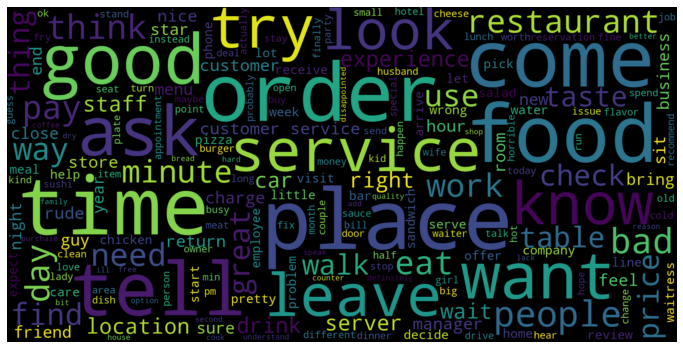

In [94]:
# Now creating the WordCloud for Negatively classified reviews
wordcloud = WordCloud(width=1600, height=800, max_font_size=200).generate(neg_text)
plt.figure(figsize=(12,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

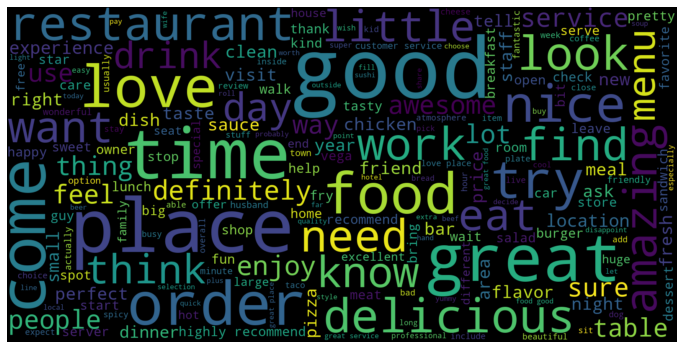

In [95]:
# Now for positive...
wordcloud = WordCloud(width=1600, height=800, max_font_size=200).generate(pos_text)
plt.figure(figsize=(12,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

## Traditional Supervised Machine Learning Models

### Implemention of Count Vectorizer - unigrams

In [96]:
# Bag-of-words vectorizing requirements
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split

In [97]:
# Feature Engineering
phrase = np.array(reviews_train['reviews_cleaned'])
sentiments = np.array(reviews_train['review_type'])

# Build train and test datasets
phrase_train, phrase_test, sentiments_train, sentiments_test = train_test_split(phrase, sentiments,
                                                                               test_size=0.2, random_state=4)

In [98]:
# Now, see how different tokens are in 2 different classes

In [99]:
# CountVectorizer - object to count number of times token appears
cv = CountVectorizer(stop_words='english', max_features=10000)

# Fit and transform the corpus to CV
cv_train_features = cv.fit_transform(phrase_train) # this is the equivalent of X_counts in other tutorials

#When BOW is applied to the text, count of each word is stored in the document matrix

In [ ]:
# The full count vectorizer object just to have in case any issues
# CountVectorizer(stop_words='english' analyzer='word',
                    # ngram_range=(1, 1), max_df=0.8,
                    # min_df=7, max_features=100, tokenizer=lambda doc: doc, lowercase=False))

In [100]:
# Transform test reviews into features
cv_test_features = cv.transform(phrase_test)

In [101]:
print('BOW model:> Train features shape:', cv_train_features.shape,' Test features shape:', cv_test_features.shape)

BOW model:> Train features shape: (1600, 10000)  Test features shape: (400, 10000)


In [102]:
# Make df out of the train CV matrix
# Each row represents 1 review in set, 1 or 0 for if token is represented
r = pd.SparseDataFrame(cv_train_features, columns=cv.get_feature_names(), default_fill_value=0)

r.head()
# There are 950 unique words in the dataset of 891 reviews

/anaconda3/envs/nlp-36/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: SparseDataFrame is deprecated and will be removed in a future version.
Use a regular DataFrame whose columns are SparseArrays instead.

See http://pandas.pydata.org/pandas-docs/stable/user_guide/sparse.html#migrating for more.

  This is separate from the ipykernel package so we can avoid doing imports until
/anaconda3/envs/nlp-36/lib/python3.6/site-packages/pandas/core/sparse/frame.py:257: FutureWarning: SparseSeries is deprecated and will be removed in a future version.
Use a Series with sparse values instead.

    >>> series = pd.Series(pd.SparseArray(...))

See http://pandas.pydata.org/pandas-docs/stable/user_guide/sparse.html#migrating for more.

  sparse_index=BlockIndex(N, blocs, blens),
/anaconda3/envs/nlp-36/lib/python3.6/site-packages/pandas/core/frame.py:3451: FutureWarning: SparseSeries is deprecated and will be removed in a future version.
Use a Series with sparse values instead.

  

,aaa,aback,abandon,abandoned,abandoning,abd,abilities,ability,able,abondigas,...,zip,zipang,zipcar,zipped,zipping,zips,zipsters,ziti,zone,zucchini
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,3,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [103]:
r.shape

(1600, 10000)

### Implemention of Count Vectorizer - bigrams

In [104]:
cv2 = CountVectorizer(stop_words='english', ngram_range=(2, 2), max_features=10000)
cv_train_features2 = cv2.fit_transform(phrase_train)
cv_train_features2.shape

(1600, 10000)

In [105]:
cv2.get_feature_names()

['aaa action',
 'able cancel',
 'able enjoy',
 'able finish',
 'able handle',
 'able hold',
 'able order',
 'able use',
 'able walk',
 'absolute worst',
 'absolutely amazing',
 'absolutely awful',
 'absolutely love',
 'absolutely outrageous',
 'absolutely taste',
 'absolutely terrible',
 'ac unit',
 'ac units',
 'ac working',
 'acknowledge presence',
 'act like',
 'acted like',
 'active renter',
 'acts like',
 'actually got',
 'actually ordered',
 'actually pretty',
 'actually quite',
 'actually really',
 'actually speak',
 'add drink',
 'added bonus',
 'added file',
 'added list',
 'adding spinach',
 'additional cost',
 'additional fee',
 'adult lemonade',
 'advice friend',
 'afford urgent',
 'agent collins',
 'ago bought',
 'ago im',
 'ago said',
 'agree reviews',
 'ahead order',
 'ahead time',
 'ahi tuna',
 'ahwatukee location',
 'air conditioning',
 'airport food',
 'ajax location',
 'aka papa',
 'al pastor',
 'alexanders pizza',
 'allergy shot',
 'allowed enter',
 'allowed walk',


### Implementation of Tfidf Vectorizer - goal = scale down impact of tokens that occur very frequently

In [106]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [107]:
# Build the TFIDF features on train reviews
tv = TfidfVectorizer(min_df=0.0, max_df=1.0, ngram_range=(1,2),
                    sublinear_tf=True)
tv_train_features = tv.fit_transform(phrase_train)
tv_train_features.shape

(1600, 99054)

In [108]:
# Transform test reviews into features
tv_test_features = tv.transform(phrase_test)

In [109]:
tv.get_feature_names()

['aaa',
 'aaa action',
 'aaa shops',
 'aaa took',
 'aaa very',
 'aback',
 'aback to',
 'abandon',
 'abandon shops',
 'abandoned',
 'abandoned by',
 'abandoned suit',
 'abandoning',
 'abandoning your',
 'abd',
 'abd classsoo',
 'abilities',
 'abilities which',
 'ability',
 'ability as',
 'ability to',
 'able',
 'able to',
 'abondigas',
 'abondigas sucked',
 'abordables',
 'abordables et',
 'about',
 'about active',
 'about additional',
 'about all',
 'about also',
 'about am',
 'about an',
 'about and',
 'about another',
 'about any',
 'about arugula',
 'about as',
 'about at',
 'about badger',
 'about barvolo',
 'about before',
 'about being',
 'about blinds',
 'about blocks',
 'about bloody',
 'about brussel',
 'about bubbles',
 'about burgers',
 'about but',
 'about cars',
 'about cecils',
 'about color',
 'about coming',
 'about contract',
 'about cracking',
 'about customer',
 'about customers',
 'about dam',
 'about days',
 'about deep',
 'about delivery',
 'about dessert',
 'abou

In [110]:
print('TFIDF Model:> Train features shape:', tv_train_features.shape, ' Test features shape:', tv_test_features.shape)

TFIDF Model:> Train features shape: (1600, 99054)  Test features shape: (400, 99054)


In [111]:
# Can also apply TfidfVectorizer on Tokenized Text
def dummy_fun(doc):
    return doc

tfidf = TfidfVectorizer(analyzer='word', tokenizer=dummy_fun, preprocessor=dummy_fun, token_pattern=None)
tfidf_features = tfidf.fit_transform(reviews['reviews_tokenized'])
tfidf_features.shape

(8930, 23216)

In [112]:
tfidf.get_feature_names()

['aaa',
 'aaahe',
 'aaliyah',
 'aamco',
 'aargosy',
 'aaron',
 'aarons',
 'aaronwas',
 'aarp',
 'aawl',
 'aback',
 'abalone',
 'abandon',
 'abbas',
 'abbey',
 'abbie',
 'abd',
 'abdomen',
 'abducted',
 'abel',
 'aber',
 'abhorrent',
 'abide',
 'ability',
 'abiltiie',
 'able',
 'abode',
 'abominable',
 'abomination',
 'abondigas',
 'abordable',
 'abound',
 'aboutlet',
 'aboutso',
 'aboveaverage',
 'abovepar',
 'abraham',
 'abrams',
 'abrasive',
 'abrupt',
 'abruptly',
 'abs',
 'absence',
 'absent',
 'absolument',
 'absolute',
 'absolutely',
 'absorb',
 'absorbent',
 'abstract',
 'absurd',
 'absurdly',
 'abundance',
 'abundant',
 'abundantly',
 'abuse',
 'abusednot',
 'abusedshe',
 'abuser',
 'abusive',
 'abysmally',
 'abzocke',
 'acadamy',
 'academically',
 'academy',
 'acai',
 'acc',
 'accent',
 'accentuate',
 'accept',
 'acceptable',
 'accepted',
 'access',
 'accessed',
 'accessibility',
 'accessible',
 'accessoriesdcor',
 'accessory',
 'accident',
 'accidentally',
 'acclimation',
 'a

## Sentiment Analysis Using Term Frequencies From CV

In [113]:
cvector = CountVectorizer(min_df = 0.0, max_df = 1.0, ngram_range=(1,2))
cvector.fit(reviews.reviews_lemmatized)

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=True, max_df=1.0, max_features=None, min_df=0.0,
                ngram_range=(1, 2), preprocessor=None, stop_words=None,
                strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, vocabulary=None)

In [114]:
# Tells us how many words the cvector extracted out of the corpus
len(cvector.get_feature_names())

280465

In [115]:
# Term frequency for negative sentiments
neg_matrix = cvector.transform(reviews[reviews.review_type == '0'].reviews_lemmatized)
pos_matrix = cvector.transform(reviews[reviews.review_type == '1'].reviews_lemmatized)

In [116]:
neg_words = neg_matrix.sum(axis=0)
neg_words_freq = [(word, neg_words[0, idx]) for word, idx in cvector.vocabulary_.items()]
neg_tf = pd.DataFrame(list(sorted(neg_words_freq, key = lambda x: x[1], reverse=True)), columns=
                     ['Terms', 'negative'])
# Print out top most-frequent terms in negative reviews
neg_tf.head()

,Terms,negative
0,food,1347
1,time,1269
2,place,1232
3,order,1196
4,service,1129


In [117]:
neg_tf_df = neg_tf.set_index('Terms')
neg_tf_df.head()

,negative
Terms,
food,1347
time,1269
place,1232
order,1196
service,1129


In [118]:
# Term frequency for positive sentiments
pos_words = pos_matrix.sum(axis=0)
pos_words_freq = [(word, pos_words[0, idx]) for word, idx in cvector.vocabulary_.items()]
pos_words_tf = pd.DataFrame(list(sorted(pos_words_freq, key = lambda x: x[1], reverse=True)), columns=
                           ['Terms','positive'])
pos_words_tf_df = pos_words_tf.set_index('Terms')
pos_words_tf_df.head()

,positive
Terms,
good,4365
great,3565
place,3488
food,3023
time,2503


In [119]:
# Total term frequency for all sentiments
term_freq_df = pd.concat([neg_tf_df, pos_words_tf_df], axis=1, sort=True)
term_freq_df['total'] = (term_freq_df['negative'] + term_freq_df['positive'])

# Print top 20 terms sorted by combined positive and negative total
term_freq_df.sort_values(by='total',ascending=False).head(20)

,negative,positive,total
good,946,4365,5311
place,1232,3488,4720
food,1347,3023,4370
great,357,3565,3922
time,1269,2503,3772
service,1129,2207,3336
come,1102,2111,3213
like,1043,2064,3107
order,1196,1573,2769
try,586,1626,2212


Text(0.5, 1.0, 'Top 500 Phrases in Yelp Reviews')

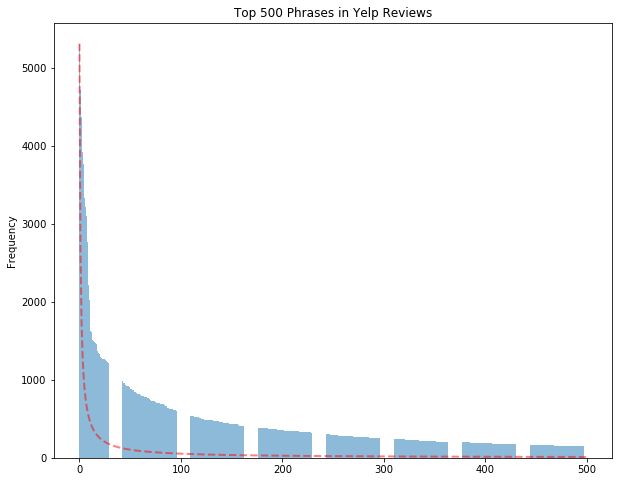

In [120]:
# Frequency plot of top frequent tokens
y_pos = np.arange(500)
plt.figure(figsize=(10,8))
s = 1
# The frequency of any word = inversely proportional to its rank in the frequency table
# Most frequent word will occur approximately twice as often as the 2nd most frequency word, 3x 3rd most, etc.
expected_zipf = [term_freq_df.sort_values(by='total', ascending=False)['total'][0]/(i+1)**s for i in y_pos]
plt.bar(y_pos, term_freq_df.sort_values(by='total', ascending=False)['total'][:500], align='center', alpha=0.5)
plt.plot(y_pos, expected_zipf, color='r', linestyle='--', linewidth=2, alpha=0.5)
plt.ylabel('Frequency')
plt.title('Top 500 Phrases in Yelp Reviews')
# X-axis is the rank of the frequency from highest on the left to 500th rank on the right
# Y-axis is the frequency observed in the corpus

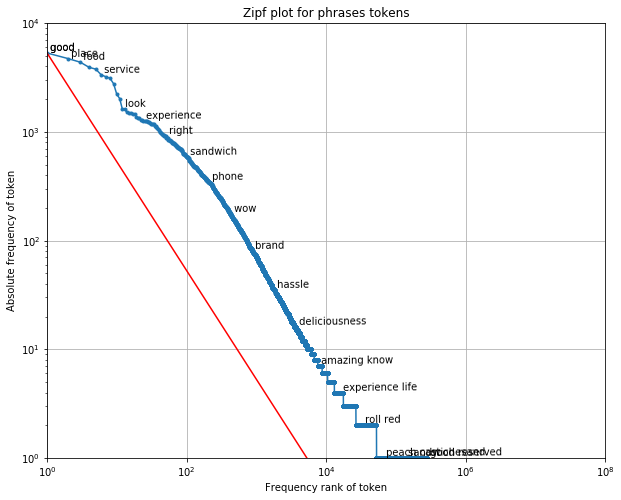

In [122]:
# Plot the absolute frequency of phrases against their rank
from pylab import *

counts = term_freq_df.total
tokens = term_freq_df.index
ranks = arange(1, len(counts)+1)
indices = argsort(-counts)
frequencies = counts[indices]
plt.figure(figsize=(10,8))
plt.ylim(1, 10**4)
plt.xlim(1, 10**8)
loglog(ranks, frequencies,  marker=".")
plt.plot([1,frequencies[0]], [frequencies[0],1], color='r')
title("Zipf plot for phrases tokens")
xlabel("Frequency rank of token")
ylabel("Absolute frequency of token")
grid(True)
for n in list(logspace(-0.5, log10(len(counts)-2), 20).astype(int)):
    dummy = text(ranks[n], frequencies[n], " " + tokens[indices[n]],
                verticalalignment="bottom",
                horizontalalignment="left", rotation=0.5)

# Shows that words like "good","place","great","service","try" are much higher in freq but ranked less
# This is because they don't have any significance in the sentiment of the movie review
# Words near the end are more indicative of review sentiment

Text(0.5, 1.0, 'Top 50 Tokens in Negative Yelp Reviews')

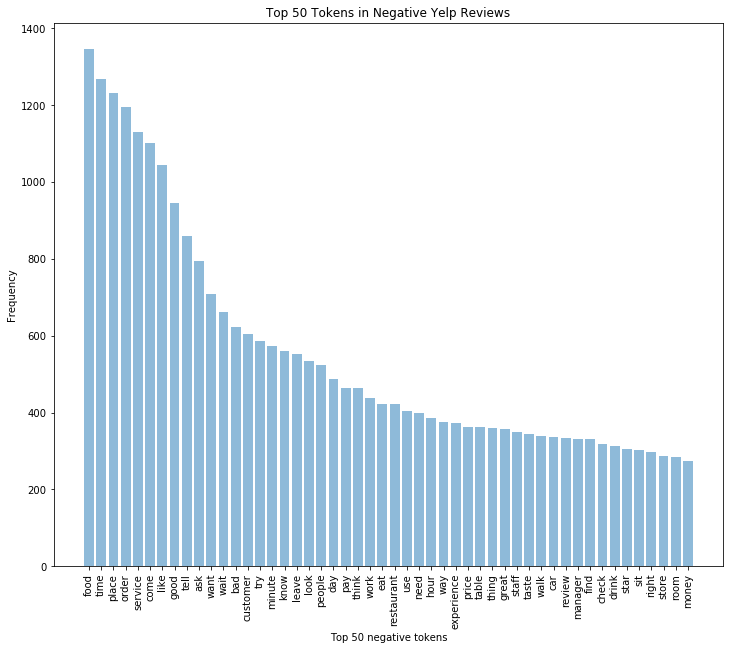

In [68]:
# Plot top 50 frequently used phrases in negative reviews
y_pos = np.arange(50)
plt.figure(figsize=(12,10))
plt.bar(y_pos, term_freq_df.sort_values(by='negative', ascending=False)['negative'][:50], align='center', alpha=0.5)
plt.xticks(y_pos, term_freq_df.sort_values(by='negative', ascending=False)['negative'][:50].index, rotation='vertical')
plt.ylabel('Frequency')
plt.xlabel('Top 50 negative tokens')
plt.title('Top 50 Tokens in Negative Yelp Reviews')

Text(0.5, 1.0, 'Top 50 Tokens in positive Yelp Reviews')

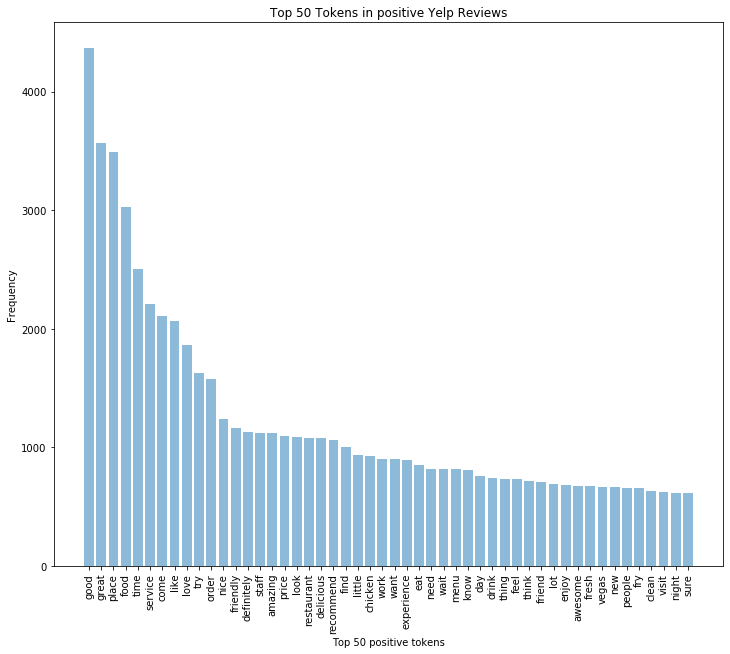

In [69]:
# Plot top 50 in positive reviews
y_pos = np.arange(50)
plt.figure(figsize=(12,10))
plt.bar(y_pos, term_freq_df.sort_values(by='positive', ascending=False)['positive'][:50], align='center', alpha=0.5)
plt.xticks(y_pos, term_freq_df.sort_values(by='positive', ascending=False)['positive'][:50].index, rotation='vertical')
plt.ylabel('Frequency')
plt.xlabel('Top 50 positive tokens')
plt.title('Top 50 Tokens in positive Yelp Reviews')

## Model Training, Prediction, and Performance evaluation

In [19]:
# Load Evaluation metric parameters
from sklearn import metrics
from sklearn.preprocessing import LabelEncoder
from sklearn.base import clone
from sklearn.preprocessing import label_binarize
from scipy import interp
from sklearn.metrics import roc_curve, auc

In [71]:
# Setting up evaulation metrics

def get_metrics(true_labels, predicted_labels):
    
    print('Accuracy:', np.round(
                        metrics.accuracy_score(true_labels,
                                              predicted_labels),
                        4))
    print('Precision:', np.round(
                        metrics.precision_score(true_labels,
                                               predicted_labels,
                                               average='weighted'),
                        4))
    print('Recall:', np.round(
                        metrics.recall_score(true_labels,
                                                predicted_labels,
                                                average='weighted'),
                        4))
    print('F1 Score:', np.round(
                        metrics.f1_score(true_labels,
                                                predicted_labels,
                                                average='weighted'),
                        4))
    
def train_predict_model(classifier,
                       train_features, train_labels,
                       test_features, test_labels):
    # Build model
    classifier.fit(train_features, train_labels)
    # Predict using model
    predictions = classifier.predict(test_features)
    return predictions

def display_confusion_matrix(true_labels, predicted_labels, classes=[1,0]):
    
    total_classes = len(classes)
    level_labels = [total_classes*[0], list(range(total_classes))]
    
    cm = metrics.confusion_Matrix(y_true=true_labels, y_pred=predicted_labels,
                                  labels=classes)
    cm_frame = pd.DataFrame(data=cm,
                            columns=pd.MultiIndex(levels=[['Predicted:'], classes],
                                                 labels=level_labels),
                            index=p.MultiIndex(levels[['Actual:'], classes],
                                              labels=level_labels))
    print(cm_frame)

def display_classification_report(true_labels, predicted_labels, classes=[1,0]):
        
    report = metrics.classification_report(y_true=true_labels,
                                           y_pred=predicted_labels,
                                           labels=classes)
    print(report)
    
def display_model_performance_metrics(true_labels, predicted_labels, classes=[1,0]):
    print('Model Performance metrics:')
    print('-'*30)
    get_metrics(true_labels=true_labels, predicted_labels=predicted_labels)
    print('\nModel Classification report:')
    print('-'*30)
    display_classification_report(true_labels=true_labels, predicted_labels=predicted_labels,
                                 classes=classes)
    
def plot_model_decision_surface(clf, train_features, train_labels, plot_step=0.02, cmap=plt.cm.RdYlBu,
                                markers=None, alphas=None, colors=None):
    
    if train_features.shape[1] != 2:
        raise ValueError("X_train should have exactly 2 columns!")
        
    x_min, x_max = train_features[:, 0].min() - plot.step, train_features[:, 0].max() + plot_step
    y_min, y_max = train_features[:, 1].min() - plot.step, train_features[:, 1].max() + plot_step
    xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),
                         np.arange(y_min, y_max, plot_step))
    
    clf_est = clone(clf)
    clf_est.fit(train_features, train_labels)
    if hasattr(clf_est, 'predict_proba'):
        Z = clf_est.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:,1]
    else:
        Z = clf_est.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    cs = plt.contour(xx, yy, Z, cmap=cmap)
    
    le = LabelEncoder()
    y_enc = le.fit_transform(train_labels)
    n_classes = len(le.classes_)
    plot_colors = ''.join(colors) if colors else [None] * n_classes
    label_names = le.classes_
    markers = markers if markers else [None] * n_classes
    alphas = alphas if alphas else [None] * n_classes
    for i, color in zip(range(n_classes), plot_colors):
        idx = np.where(y_enc == 1)
        plt.scatter(train_features[idx, 0], train_features[idx, 1], c=color,
                   label=label_names[i], cmap=cmap, edgecolors='black',
                   marker=markers[i], alpha=alphas[i])
        plt.legend()
        plt.show()

def plot_model_roc_curve(clf, features, true_labels, label_encode=None, class_names=None):
    
    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    if hasattr(clf, 'classes_'):
        class_labels = clf.classes_
    elif label_encoder:
        class_labels = label_encoder.classes_
    elif class_names:
        class_labels = class_names
    else:
        raise ValueError('Unable to derive prediction classes, please specify class names!')
    n_classes = len(class_labels)
    y_test = label_binarize(true_labels, classes=class_labels)
    if n_classes == 2:
        if hasattr(clf, 'predict_proba'):
            prob = clf.predict_proba(features)
            y_score = prob[:, prob.shape[1],-1]
        elif hasattr(clf, 'decision_function'):
            prob = clf.decision_function(features)
            y_score = prob[:, prob.shape[1]-1]
        else:
            raise AttributeError("Estimator doesn't have a probability or confidence scoring system!")
        
        fpr, tpr, _ = roc_curve(y_test, y_score)
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label='ROC curve (area = {0:0.2f})'
                                 ''.format(roc_auc),
                 linewidth=2.5)
        
    elif n_classes > 2:
        if hasattr(clf, 'predict_proba'):
            y_score = clf.predict_proba(features)
        elif hasattr(clf, 'decision_function'):
            y_score = clf.decision_function(features)
        else:
            raise AttributeError("Estimator doesn't have a probability or confidence scoring system!")
                
        for i in range(n_classes):
            fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
            roc_auc[i] = auc(fpr[i], tpr[i])
                
        # Compute micro-average ROC curve and ROC area
        fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
        roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
            
        # Compute macro-average ROC curve and ROC area
        # First aggregate all false positive rates
        all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
        # Then interpolate all ROC curves at this point
        mean_tpr = np.zeros_like(all_fpr)
        for i in range(n_classes):
            mean_tpr += interp(all_fpr, fpr[i], tpr[i])
        # Finally, average it and compute AUC
        mean_tpr /= n_classes
        fpr["macro"] = all_fpr
        tpr["macro"] - all_tpr
        roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])
            
        # Plot ROC curves
        plt.figure(figsize=(6,4))
        plt.plot(fpr["micro"], tpr["micro"],
                label='micro-average ROC curve (area = {0:0.2f})'
                        ''.format(roc_auc["micro"]), linewidth=3)
        plt.plot(fpr["macro"], tpr["macro"],
                label='macro-average ROC curve (area= {0:0.2f})'
                        ''.format(roc_auc["macro"]), linewidth=3)
            
        for i, label in enumerate(class_labels):
            plt.plot(fpr[i], tpr[i], label='ROC curve of class {0} (area = {1:0.2f})'
                                            ''.format(label, roc_auc[i]),
                     linewidth=2, linestyle=':')
    else:
        raise ValueError('Number of classes should be atleast 2 or more')
        
    plt.plot([0,1], [0,1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receive Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()

In [73]:
# Logistic Regression on CountVectorizer
from sklearn.linear_model import SGDClassifier, LogisticRegression

lr = LogisticRegression(penalty='l2', max_iter=100, C=1)

# Logistic Regression model on BOW features
lr_bow_predictions = train_predict_model(classifier=lr,
                                        train_features=cv_train_features, train_labels=sentiments_train,
                                        test_features=cv_test_features, test_labels=sentiments_test)
display_model_performance_metrics(true_labels=sentiments_test, predicted_labels=lr_bow_predictions,
                                 classes=[0,1,2,3,4])

Model Performance metrics:
------------------------------
Accuracy: 0.87
Precision: 0.87
Recall: 0.87
F1 Score: 0.87

Model Classification report:
------------------------------
              precision    recall  f1-score   support

           0       0.87      0.87      0.87       196
           1       0.87      0.87      0.87       204
           2       0.00      0.00      0.00         0
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0

   micro avg       0.87      0.87      0.87       400
   macro avg       0.35      0.35      0.35       400
weighted avg       0.87      0.87      0.87       400



/anaconda3/envs/nlp-36/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/envs/nlp-36/lib/python3.6/site-packages/numpy/lib/arraysetops.py:564: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask &= (ar1 != a)
/anaconda3/envs/nlp-36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/envs/nlp-36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


In [74]:
# Logistic Regression model on TF-IDF Features
lr_tfidf_predictions = train_predict_model(classifier=lr, train_features=tv_train_features,
                                          train_labels=sentiments_train, test_features=tv_test_features,
                                          test_labels=sentiments_test)
display_model_performance_metrics(true_labels=sentiments_test, predicted_labels=lr_tfidf_predictions,
                                 classes=[0,1,2,3,4])

Model Performance metrics:
------------------------------
Accuracy: 0.9025
Precision: 0.9038
Recall: 0.9025
F1 Score: 0.9025

Model Classification report:
------------------------------
              precision    recall  f1-score   support

           0       0.88      0.93      0.90       196
           1       0.93      0.88      0.90       204
           2       0.00      0.00      0.00         0
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0

   micro avg       0.90      0.90      0.90       400
   macro avg       0.36      0.36      0.36       400
weighted avg       0.90      0.90      0.90       400



### Keras Modeling

In [20]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, Dropout

Using TensorFlow backend.
/anaconda3/envs/nlp-36/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:493: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/anaconda3/envs/nlp-36/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:494: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/anaconda3/envs/nlp-36/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:495: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/anaconda3/envs/nlp-36/lib/python3.6/site-packages/tenso

In [41]:
# Load in larger subset of data
reviews = pd.read_csv('reviews.csv', nrows=1000000)
reviews = reviews[['stars','text']]

In [42]:
# Clean it up like above
reviews = reviews[reviews.stars != 3]

def positive_review(series):
    if series > 3:
        return "1"
    elif series < 3:
        return "0"

reviews['review_type'] = reviews['stars'].apply(positive_review)

reviews = reviews[['text', 'review_type']]

reviews.shape

(890196, 2)

In [44]:
# Make the training set, with even proportion of negative and positive reviews
negative = reviews[reviews['review_type']=='0'][:20000]
positive = reviews[reviews['review_type']=='1'][:20000]
reviews_train = positive.append(negative)
# Make the test set, with even proportion of negative and positive reviews
negative_test = reviews[reviews['review_type']=='0'].tail(20000)
positive_test = reviews[reviews['review_type']=='1'].tail(20000)
reviews_test = positive_test.append(negative_test)
# Make sure no overlap in training and test sets
sum(reviews_train.text.isin(reviews_test.text))

0

In [46]:
# Pre-Process with spaCy pipeline
tags = re.compile(r'<[^>]+>')
underscores = re.compile(r'[_+]')

def regex(text):
    text = tags.sub(' ', text)
    text = underscores.sub(' ', text)
    return text

reviews_train['regex'] = reviews_train.text.apply(lambda x: regex(x))
reviews_test['regex'] = reviews_test.text.apply(lambda x: regex(x))

def cleanup_text(doc):
    tokens = [tok.lemma_.lower().strip() for tok in doc 
              if tok.lemma_ != '-PRON-' 
              and tok.lemma_.lower() not in stopwords
              and tok.lemma_.lower() not in string.punctuation 
              and len(tok.lemma_.lower()) > 2]
    return tokens

reviews_train['lemma_tokens'] = [cleanup_text(doc) for doc in nlp.pipe(reviews_train.regex, disable=['parser', 'ner'])]
reviews_test['lemma_tokens'] = [cleanup_text(doc) for doc in nlp.pipe(reviews_test.regex, disable=['parser', 'ner'])]

In [47]:
# Label training and test sets as so
reviews_train['dataset'] = 'train'
reviews_test['dataset'] ='test'

# Combine training and testing sets into one dataset for keras pre-processing
data = reviews_train.append(reviews_test)

data.columns.values

array(['text', 'review_type', 'regex', 'lemma_tokens', 'dataset'],
      dtype=object)

In [48]:
# Keras Pre-Processing
tk = Tokenizer()

tk.fit_on_texts(data.lemma_tokens)
x = tk.texts_to_sequences(data.lemma_tokens)
x_pad = pad_sequences(x, maxlen=200, padding='post')

In [49]:
vocabulary_size = len(tk.word_counts.keys())+1
print(f'Vocab Size: {vocabulary_size}')
max_words = 200
embedding_size = 64

Vocab Size: 72670


In [50]:
# Split into x and y training and testing sets
x_train = x_pad[data.dataset == 'train']
x_test = x_pad[data.dataset == 'test']
y_train = reviews_train.review_type
y_test = reviews_test.review_type

In [59]:
# Build the model
import keras
print('Build model...')
model = Sequential()
model.add(Embedding(vocabulary_size, embedding_size, input_length=200))
model.add(LSTM(128, dropout=0.2))
model.add(Dense(1, activation='sigmoid'))

optimizer = keras.optimizers.Adam(lr=0.0001)


model.compile(loss='binary_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])

print(model.summary())

Build model...
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 200, 64)           4650880   
_________________________________________________________________
lstm_4 (LSTM)                (None, 128)               98816     
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 129       
Total params: 4,749,825
Trainable params: 4,749,825
Non-trainable params: 0
_________________________________________________________________
None


In [60]:
print('Train...')
history = model.fit(x_train, y_train,
                   batch_size=64,
                   epochs=10,
                   validation_split=0.2)
score, acc = model.evaluate(x_test, y_test,
                           batch_size=64)
print('Test Score:', score)
print('Test accuracy:', acc)

Train...
Train on 32000 samples, validate on 8000 samples
Epoch 1/10
32000/32000 [==============================] - 124s 4ms/step - loss: 0.6628 - acc: 0.6249 - val_loss: 0.9651 - val_acc: 0.0000e+00
Epoch 2/10
32000/32000 [==============================] - 123s 4ms/step - loss: 0.6611 - acc: 0.6250 - val_loss: 1.0127 - val_acc: 1.2500e-04
Epoch 3/10
32000/32000 [==============================] - 119s 4ms/step - loss: 0.6605 - acc: 0.6273 - val_loss: 0.9902 - val_acc: 0.0050
Epoch 4/10
32000/32000 [==============================] - 125s 4ms/step - loss: 0.6602 - acc: 0.6309 - val_loss: 0.9595 - val_acc: 0.0143
Epoch 5/10
32000/32000 [==============================] - 129s 4ms/step - loss: 0.6601 - acc: 0.6316 - val_loss: 0.9622 - val_acc: 0.0185
Epoch 6/10
32000/32000 [==============================] - 127s 4ms/step - loss: 0.6444 - acc: 0.6245 - val_loss: 0.9089 - val_acc: 0.0000e+00
Epoch 7/10
32000/32000 [==============================] - 128s 4ms/step - loss: 0.6381 - acc: 0.6254 -

KeyboardInterrupt: 

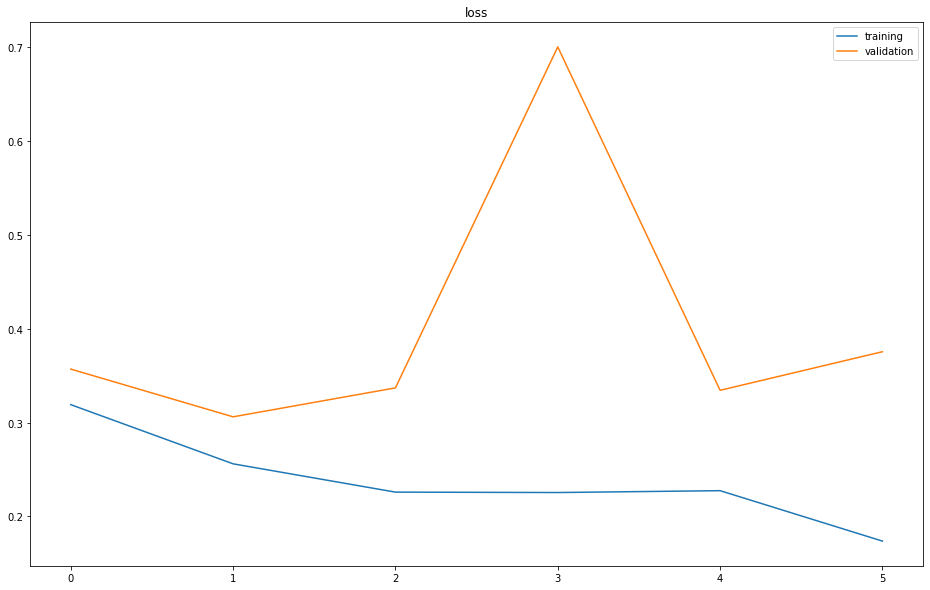

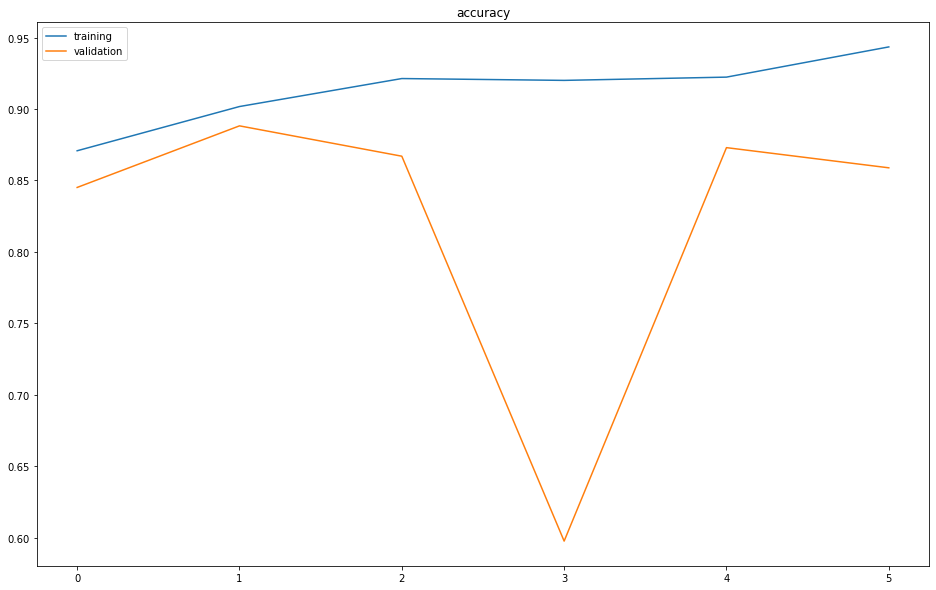

In [56]:
# Plots
plt.figure(figsize=(16,10))
plt.plot(history.epoch,history.history['loss'], label='training')
plt.plot(history.epoch,history.history['val_loss'], label='validation')
plt.title('loss')
plt.legend(loc='best')

plt.figure(figsize=(16,10))
plt.plot(history.epoch,history.history['acc'], label='training')
plt.plot(history.epoch,history.history['val_acc'], label='validation')
plt.title('accuracy')
plt.legend(loc='best');

In [57]:
scores = model.evaluate(x_test, y_test, verbose=2)
print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

acc: 90.06%
